In [1]:
from gekko import GEKKO 
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

In [2]:
def sis_time_dependant(t,i,beta,gamma):
    return beta*(1-i)*i-gamma*i 

In [3]:
def sis_constant(nt,nf,beta,gamma,umax,b):
    m=GEKKO(remote=False)
    i0=0.01
    b=b
    nt=nt
    tf=nf
    u_max=umax
    time=np.linspace(0,tf,nt)
    m.time=time

    beta=beta
    x1=m.Var(value=i0,lb=0,ub=1)
    x2=m.Var(value=0)
    u=m.Param(value=u_max/2)

    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)

    m.Equation(x1.dt()==-beta*x1**2+(beta-gamma-u)*x1+u)
    m.Equation(x2.dt()==b*u**2)
    
    m.Obj(-x1*final+x2*final)
    m.options.IMODE=6
    m.solve(disp=False)
    return x1.value,u.value,(-x1.value[-1]+x2.value[-1])

def sis_optimal(nt,nf,beta,gamma,umax,b):
    m=GEKKO(remote=False)
    i0=0.01
    b=b
    nt=nt
    tf=nf
    u_max=umax
    time=np.linspace(0,tf,nt)
    m.time=time

    beta=beta
    x1=m.Var(value=i0,lb=0,ub=1)
    x2=m.Var(value=0)
    u=m.Var(value=u_max,lb=0,ub=u_max)

    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)

    m.Equation(x1.dt()==-beta*x1**2+(beta-gamma-u)*x1+u)
    m.Equation(x2.dt()==b*u**2)
    
    m.Obj(-x1*final+x2*final)
    m.options.IMODE=6
    m.solve(disp=False)
    return x1.value,u.value,(-x1.value[-1]+x2.value[-1])

def sis_heuristic(nt,nf,beta,gamma,umax,s_func,b):
    m=GEKKO(remote=False)
    i0=0.01
    b=b
    nt=nt
    tf=nf
    u_max=umax
    time=np.linspace(0,tf,nt)
    m.time=time

    beta=beta
    x1=m.Var(value=i0,lb=0,ub=1)
    x2=m.Var(value=0)
    u=m.Param(value=s_func*u_max)

    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)

    m.Equation(x1.dt()==-beta*x1**2+(beta-gamma-u)*x1+u)
    m.Equation(x2.dt()==b*u**2)
    
    m.Obj(-x1*final+x2*final)
    m.options.IMODE=6
    m.solve(disp=False)
    return x1.value,u.value,(-x1.value[-1]+x2.value[-1])

function_dict={'opt':sis_optimal,'hero':sis_heuristic,'const':sis_constant}

In [4]:
%%time
nt=500
tf=5
time=np.linspace(0,tf,nt)
gamma=0.1
beta=1
b=15
u_max=0.06
s_no=1-(solve_ivp(sis_time_dependant,[0,tf],[0.01],t_eval=time,args=(beta,gamma))).y[0]
i_opt,u_opt,_=function_dict['opt'](nt,tf,beta,gamma,u_max,b)
i_hero,u_hero,_=function_dict['hero'](nt,tf,beta,gamma,u_max,s_no,b)
i_const,u_const,_=function_dict['const'](nt,tf,beta,gamma,u_max,b)

Wall time: 2.96 s


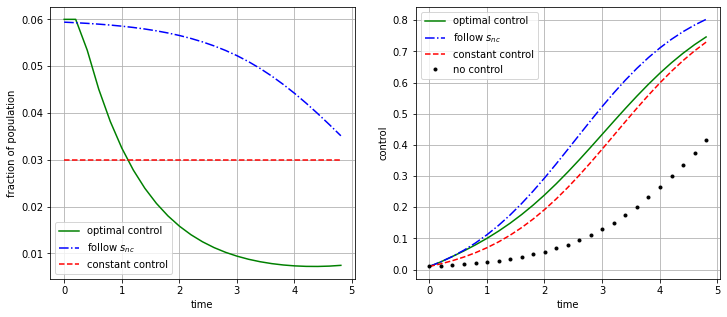

In [5]:
i_s=[i_opt,i_hero,i_const,1-s_no]
u_s=[u_opt,u_hero,u_const]
colors=['g','blue','red','k']
shapes=['-','-.','--','.']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=20
fig,ax=plt.subplots(1,2,figsize=(12,5))
for i in range(3):
    ax[0].plot(time[::ns],u_s[i][::ns],shapes[i],color=colors[i],label=labels[i])
ax[0].grid()
ax[0].set_xlabel('time')
ax[0].set_ylabel('fraction of population')
ax[0].legend()
for i in range(4):
    ax[1].plot(time[::ns],i_s[i][::ns],shapes[i],color=colors[i],label=labels[i])

ax[1].grid()
ax[1].set_xlabel('time')
ax[1].set_ylabel('control')
ax[1].legend()
plt.savefig('SIS-comp-1.pdf',bbox_inches='tight')

## varying beta

In [6]:
%%time
nt=500
tf=5
time=np.linspace(0,tf,nt)
gamma=0.1
beta_list=np.linspace(0,2,20)
b=15
u_max=0.06

j_opt=np.zeros(len(beta_list))
j_hero=np.zeros(len(beta_list))
j_const=np.zeros(len(beta_list))
j_no=np.zeros(len(beta_list))

for index,beta in enumerate(beta_list):
    print('\r',index,end="")
    s_no=1-(solve_ivp(sis_time_dependant,[0,tf],[0.01],t_eval=time,args=(beta,gamma))).y[0]
    _,_,j_opt[index]=function_dict['opt'](nt,tf,beta,gamma,u_max,b)
    _,_,j_hero[index]=function_dict['hero'](nt,tf,float(beta),gamma,u_max,s_no,b)
    _,_,j_const[index]=function_dict['const'](nt,tf,beta,gamma,u_max,b)
    j_no[index]=-1+s_no[-1]

 19Wall time: 1min 42s


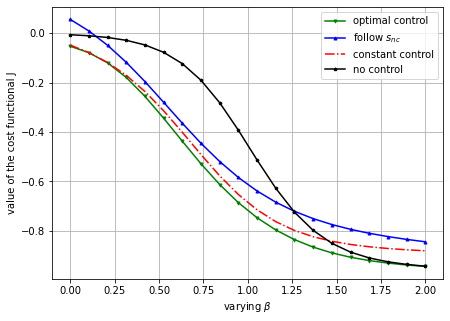

In [7]:
j_s=[j_opt,j_hero,j_const,j_no]

colors=['g','blue','red','k']
shapes=['-v','-^','-.','-p']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=1
fig,ax=plt.subplots(1,1,figsize=(7,5))

for i in range(4):
    ax.plot(beta_list[::ns],j_s[i][::ns],shapes[i],color=colors[i],label=labels[i],ms=3)

ax.grid()
ax.set_xlabel('varying $\\beta$')
ax.set_ylabel('value of the cost functional J')
ax.legend()
plt.savefig('SIS-comp-varying-beta.pdf',bbox_inches='tight')

## varying gamma

In [8]:
%%time
nt=500
tf=5
time=np.linspace(0,tf,nt)
gamma_list=np.linspace(0,2,20)
beta=1
b=15
u_max=0.06

j_opt=np.zeros(len(gamma_list))
j_hero=np.zeros(len(gamma_list))
j_const=np.zeros(len(gamma_list))
j_no=np.zeros(len(gamma_list))

for index,gamma in enumerate(gamma_list):
    print('\r',index,end="")
    s_no=1-(solve_ivp(sis_time_dependant,[0,tf],[0.01],t_eval=time,args=(beta,gamma))).y[0]
    _,_,j_opt[index]=function_dict['opt'](nt,tf,beta,gamma,u_max,b)
    _,_,j_hero[index]=function_dict['hero'](nt,tf,float(beta),float(gamma),u_max,s_no,b)
    _,_,j_const[index]=function_dict['const'](nt,tf,beta,gamma,u_max,b)
    j_no[index]=-1+s_no[-1]

 19Wall time: 49.4 s


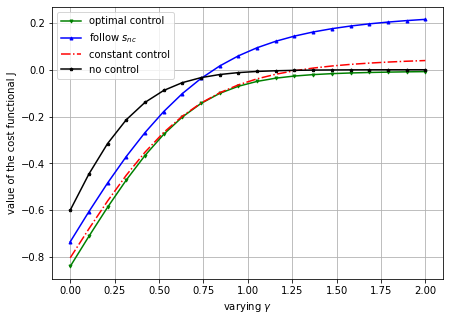

In [9]:
j_s=[j_opt,j_hero,j_const,j_no]

colors=['g','blue','red','k']
shapes=['-v','-^','-.','-p']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=1
fig,ax=plt.subplots(1,1,figsize=(7,5))

for i in range(4):
    ax.plot(gamma_list[::ns],j_s[i][::ns],shapes[i],color=colors[i],label=labels[i],ms=3)

ax.grid()
ax.set_xlabel('varying $\\gamma$')
ax.set_ylabel('value of the cost functional J')
ax.legend()
plt.savefig('SIS-comp-varying-gamma.pdf',bbox_inches='tight')

## varying T

In [10]:
%%time
nt=500
tf_list=np.linspace(1,10,20)

gamma=0.1
beta=1
b=15
u_max=0.06

j_opt=np.zeros(len(tf_list))
j_hero=np.zeros(len(tf_list))
j_const=np.zeros(len(tf_list))
j_no=np.zeros(len(tf_list))

for index,tf in enumerate(tf_list):
    time=np.linspace(0,tf,nt)
    print('\r',index,end="")
    s_no=1-(solve_ivp(sis_time_dependant,[0,tf],[0.01],t_eval=time,args=(beta,gamma))).y[0]
    _,_,j_opt[index]=function_dict['opt'](nt,tf,beta,gamma,u_max,b)
    _,_,j_hero[index]=function_dict['hero'](nt,tf,float(beta),float(gamma),u_max,s_no,b)
    _,_,j_const[index]=function_dict['const'](nt,tf,beta,gamma,u_max,b)
    j_no[index]=-1+s_no[-1]

 19Wall time: 1min 10s


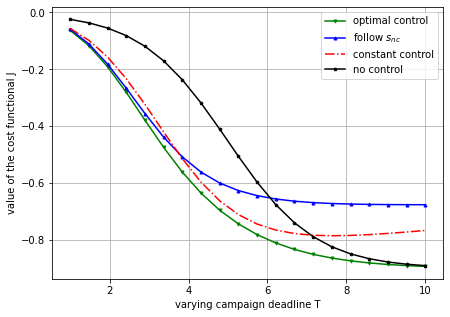

In [11]:
j_s=[j_opt,j_hero,j_const,j_no]

colors=['g','blue','red','k']
shapes=['-v','-^','-.','-p']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=1
fig,ax=plt.subplots(1,1,figsize=(7,5))

for i in range(4):
    ax.plot(tf_list[::ns],j_s[i][::ns],shapes[i],color=colors[i],label=labels[i],ms=3)

ax.grid()
ax.set_xlabel('varying campaign deadline T')
ax.set_ylabel('value of the cost functional J')
ax.legend()
plt.savefig('SIS-comp-varying-T.pdf',bbox_inches='tight')

## varying b

In [12]:
%%time
nt=500
tf=5

gamma=0.1
beta=1
b_list=np.linspace(10,30,20)
u_max=0.06

j_opt=np.zeros(len(b_list))
j_hero=np.zeros(len(b_list))
j_const=np.zeros(len(b_list))
j_no=np.zeros(len(b_list))

for index,b in enumerate(b_list):
    time=np.linspace(0,tf,nt)
    print('\r',index,end="")
    s_no=1-(solve_ivp(sis_time_dependant,[0,tf],[0.01],t_eval=time,args=(beta,gamma))).y[0]
    _,_,j_opt[index]=function_dict['opt'](nt,tf,beta,gamma,u_max,b)
    _,_,j_hero[index]=function_dict['hero'](nt,tf,float(beta),float(gamma),u_max,s_no,b)
    _,_,j_const[index]=function_dict['const'](nt,tf,beta,gamma,u_max,b)
    j_no[index]=-1+s_no[-1]

 19Wall time: 56.5 s


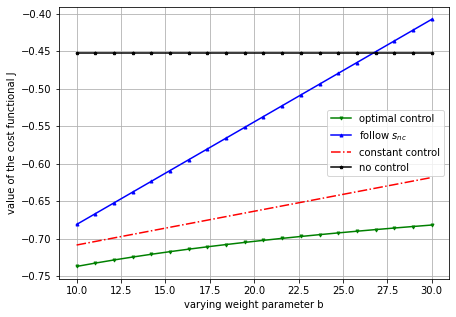

In [13]:
j_s=[j_opt,j_hero,j_const,j_no]

colors=['g','blue','red','k']
shapes=['-v','-^','-.','-p']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=1
fig,ax=plt.subplots(1,1,figsize=(7,5))

for i in range(4):
    ax.plot(b_list[::ns],j_s[i][::ns],shapes[i],color=colors[i],label=labels[i],ms=3)

ax.grid()
ax.set_xlabel('varying weight parameter b')
ax.set_ylabel('value of the cost functional J')
ax.legend()
plt.savefig('SIS-comp-varying-b.pdf',bbox_inches='tight')